<a href="https://colab.research.google.com/github/douglasmmachado/MedicineConsumption/blob/main/notebooks/time_series/unified_approach/5_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5 - Forecasting and prediction



---



---



In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import math as m

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,  mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV


df_agg_clusters_4_url = "https://raw.githubusercontent.com/douglasmmachado/MedicineConsumption/main/datasets/time_series/clustered/df_clustered_4.csv"
df_agg_clusters_8_url = "https://raw.githubusercontent.com/douglasmmachado/MedicineConsumption/main/datasets/time_series/clustered/df_clustered_8.csv"
df_agg_clusters_12_url = "https://raw.githubusercontent.com/douglasmmachado/MedicineConsumption/main/datasets/time_series/clustered/df_clustered_12.csv"
df_agg_clusters_18_url = "https://raw.githubusercontent.com/douglasmmachado/MedicineConsumption/main/datasets/time_series/clustered/df_clustered_18.csv"

df_agg_clusters_4 = pd.read_csv(df_agg_clusters_4_url)
df_agg_clusters_4 = df_agg_clusters_4.drop(['index', 'ID_SITE_RATTACHE', 'SEASONAL', 'TREND', 'RESID'], axis = 1)
df_agg_clusters_4['HOSPI_CODE_UCD'] = df_agg_clusters_4['HOSPI_CODE_UCD'].astype(str)


df_agg_clusters_8 = pd.read_csv(df_agg_clusters_8_url)
df_agg_clusters_8 = df_agg_clusters_8.drop(['index', 'ID_SITE_RATTACHE', 'SEASONAL', 'TREND', 'RESID'], axis = 1)
df_agg_clusters_8['HOSPI_CODE_UCD'] = df_agg_clusters_8['HOSPI_CODE_UCD'].astype(str)

df_agg_clusters_12 = pd.read_csv(df_agg_clusters_12_url)
df_agg_clusters_12 = df_agg_clusters_12.drop(['index', 'ID_SITE_RATTACHE', 'SEASONAL', 'TREND', 'RESID'], axis = 1)
df_agg_clusters_12['HOSPI_CODE_UCD'] = df_agg_clusters_12['HOSPI_CODE_UCD'].astype(str)

df_agg_clusters_18 = pd.read_csv(df_agg_clusters_18_url)
df_agg_clusters_18 = df_agg_clusters_18.drop(['index', 'ID_SITE_RATTACHE', 'SEASONAL', 'TREND', 'RESID'], axis = 1)
df_agg_clusters_18['HOSPI_CODE_UCD'] = df_agg_clusters_18['HOSPI_CODE_UCD'].astype(str)

medicines = ['3400892088310','3400892075761','3400892203645',
             '3400892065366','3400892052120','3400891996128',
             '3400893826706','3400893736135','3400893875490',
             '3400890837149','3400891235203','3400891225037',
             '3400891191226','3400892729589','3400892745848',
             '3400892697789','3400892761527','3400893022634',
             '3400892761695','3400892669236','3400892508566']

In [28]:
df_agg_clusters_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2479 entries, 0 to 2478
Data columns (total 36 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   HOSPI_CODE_UCD  2479 non-null   object 
 1   QUANTITY        2479 non-null   float64
 2   N_UFS           2479 non-null   float64
 3   DATE            2479 non-null   object 
 4   N_ETB           2479 non-null   float64
 5   POPULATION      2479 non-null   float64
 6   P_MEDICAL       2479 non-null   float64
 7   PN_MEDICAL      2479 non-null   float64
 8   LIT_HC          2479 non-null   float64
 9   LIT_HP          2479 non-null   float64
 10  SEJ_MCO         2479 non-null   float64
 11  SEJ_HAD         2479 non-null   float64
 12  SEJ_PSY         2479 non-null   float64
 13  SEJ_SSR         2479 non-null   float64
 14  SEJ_SLD         2479 non-null   float64
 15  MONTH_1         2479 non-null   int64  
 16  MONTH_2         2479 non-null   int64  
 17  MONTH_3         2479 non-null   i

## 5.1 - New database composition based on clusters

## 5.2 - Building forecasting models based on clusters

In [ ]:
def plot_pred(y_pred, y_test, medicine):
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # Scatter plot for y_pred
    axes[0].scatter(np.arange(len(y_pred)), y_pred, marker='o', label='Predicted', color='blue')

    # Scatter plot for y_test
    axes[0].scatter(np.arange(len(y_test)), y_test, marker='x', label='Actual', color='red')

    # Set axes labels and title
    axes[0].set_xlabel('Test samples')
    axes[0].set_ylabel('Quantity')
    axes[0].set_title(f'Predicted vs Actual: {medicine}')
    axes[0].legend()

    epsilon = 0.001
    mape_array = np.abs(y_test - y_pred) / np.maximum(epsilon, np.abs(y_test))

    # Stem plot for MAPE
    stem = axes[1].stem(np.arange(len(y_pred)), mape_array, markerfmt='bo', linefmt='b-', basefmt='r-', label='MAPE')
    axes[1].set_xlabel('Test samples')
    axes[1].set_ylabel('MAPE')
    axes[1].set_title(f'MAPE for: {medicine}')
    axes[1].set_ylim([0, 1])

    mape_target = 0.3
    axes[1].axhline(y=mape_target, color='g', linestyle='--', label=f'Target MAPE ({mape_target:.2f})')

    # Adjust layout
    plt.tight_layout()

    # Add a legend
    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].legend(handles=handles, labels=labels, loc='best')

    # Adjust width of subplots and margins
    fig.subplots_adjust(wspace=0.4, left=0.1, right=0.9)

    plt.show()

In [30]:
def test_1_baseline(df, medicine, df_scores):
  print()
  print(100*'-')
  print('Medicine:' + str(medicine))

  X = df[df['HOSPI_CODE_UCD'] == medicine].drop(['QUANTITY', 'HOSPI_CODE_UCD',
                                                 'DATE'], axis=1).values

  y = df[df['HOSPI_CODE_UCD'] == medicine]['QUANTITY'].values

  if m.ceil(len(X) * 0.1) == 1:
    print('Dataset too small')
    test_size = 2
  else:
    test_size = 0.2

  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                      test_size = test_size,
                                                      random_state = 42)
  print(f'Size of data set: {len(X)}')
  print(f'Size of training set: {len(X_train)}')
  print(f'Size of test set: {len(X_test)}')

  # Define the parameter distributions for RandomizedSearchCV
  param_grid = {
      'max_depth': np.arange(2, 8, 1),
      'n_estimators': np.arange(2, max(int(m.ceil(len(X_train)*0.1)),3), 1),
      'max_features': ['sqrt', 1, 2]
  }
  depth_len = param_grid['max_depth'].size
  estimators_len = param_grid['n_estimators'].size

  print(f'Size of grid search: {depth_len * estimators_len}')

  # Create the RandomizedSearchCV object
  grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                             param_grid=param_grid,
                             scoring = 'neg_mean_absolute_percentage_error',
                             cv = 5,
                             n_jobs = -1)

  ''' >3 : the fold and candidate parameter indexes
      are also displayed together with the starting time of the computation.
  '''
  # Fit the RandomizedSearchCV object to the data
  grid_search.fit(X_train, y_train)

  # Get the best estimator
  best_estimator = grid_search.best_estimator_

  # Make predictions using the best estimator
  y_pred = best_estimator.predict(X_test)

  # Calculate R^2 score
  r2 = r2_score(y_test, y_pred)

  # Calculate MAE
  mae = mean_absolute_error(y_test, y_pred)

  # Calculate MAPE
  mape = mean_absolute_percentage_error(y_test, y_pred)

  # Calculate RMSE
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))

  # Print the best parameters, best score, and evaluation metrics
  print('Best Parameters: ', grid_search.best_params_)
  print('Training Score (MAPE): ', round(grid_search.best_score_, 3))
  print(10*'-' + 'Test scores' + 10*'-')
  print('R^2 Score:', round(r2, 3))
  print('MAE:', round(mae, 3))
  print('MAPE:', round(mape, 3))
  print('RMSE:', round(rmse, 3))
  print()


  # Create the new row as a DataFrame
  new_row = pd.DataFrame({'HOSPI_CODE_UCD': ['CODE_UCD_'+str(medicine)],
                          'R2': [r2],
                          'RMSE': [rmse],
                          'MAE': [mae],
                          'MAPE': [mape]})

  # Append the new row to the DataFrame
  df_scores = pd.concat([df_scores, new_row], ignore_index=True)

  # plot pred x test
  plot_pred(y_pred, y_test, medicine)
  print()
  plt.close()



  # Return the updated DataFrame
  return df_scores



----------------------------------------------------------------------------------------------------
Medicine:3400892088310
Size of data set: 105
Size of training set: 84
Size of test set: 21
Size of grid search: 42
Best Parameters:  {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 5}
Training Score (MAPE):  -6.622
----------Test scores----------
R^2 Score: 0.823
MAE: 452.96
MAPE: 0.104
RMSE: 750.325



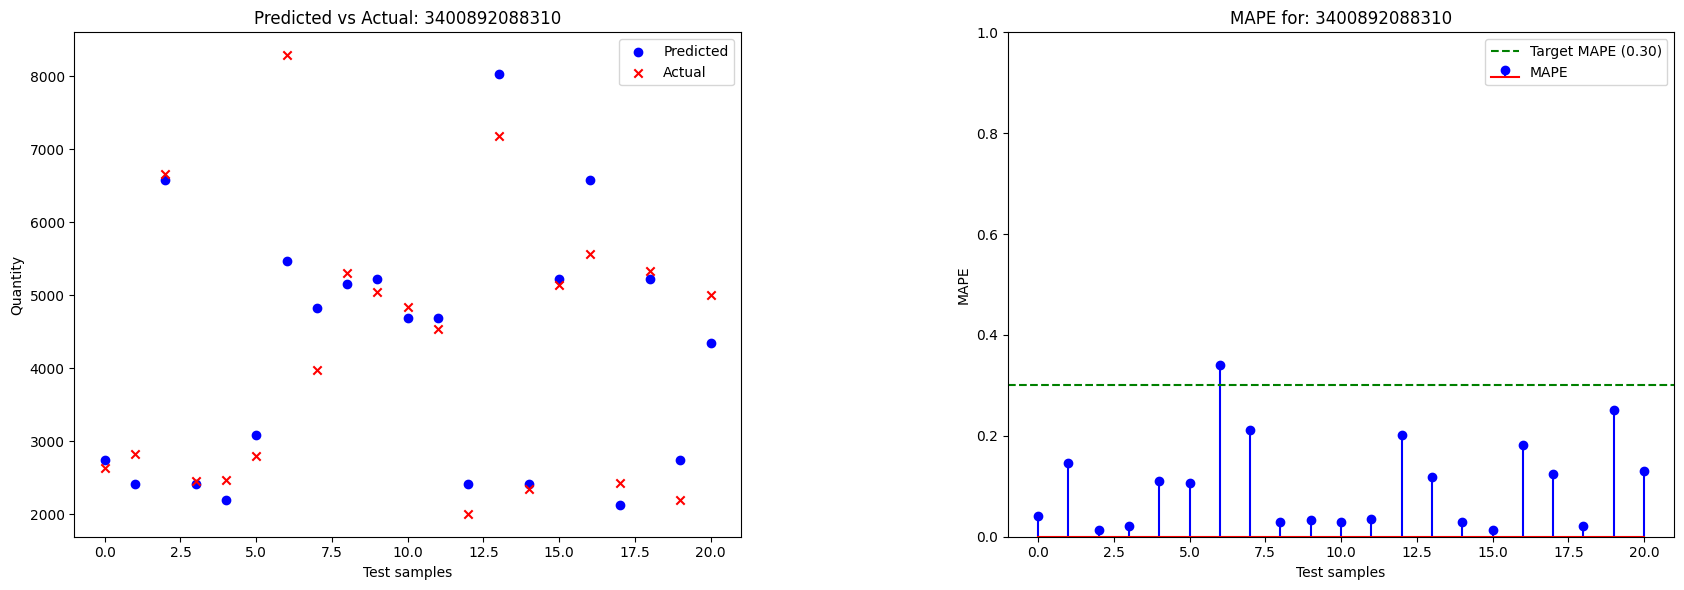



----------------------------------------------------------------------------------------------------
Medicine:3400892075761
Size of data set: 127
Size of training set: 101
Size of test set: 26
Size of grid search: 54
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 6}
Training Score (MAPE):  -0.526
----------Test scores----------
R^2 Score: 0.975
MAE: 366.338
MAPE: 0.114
RMSE: 517.951



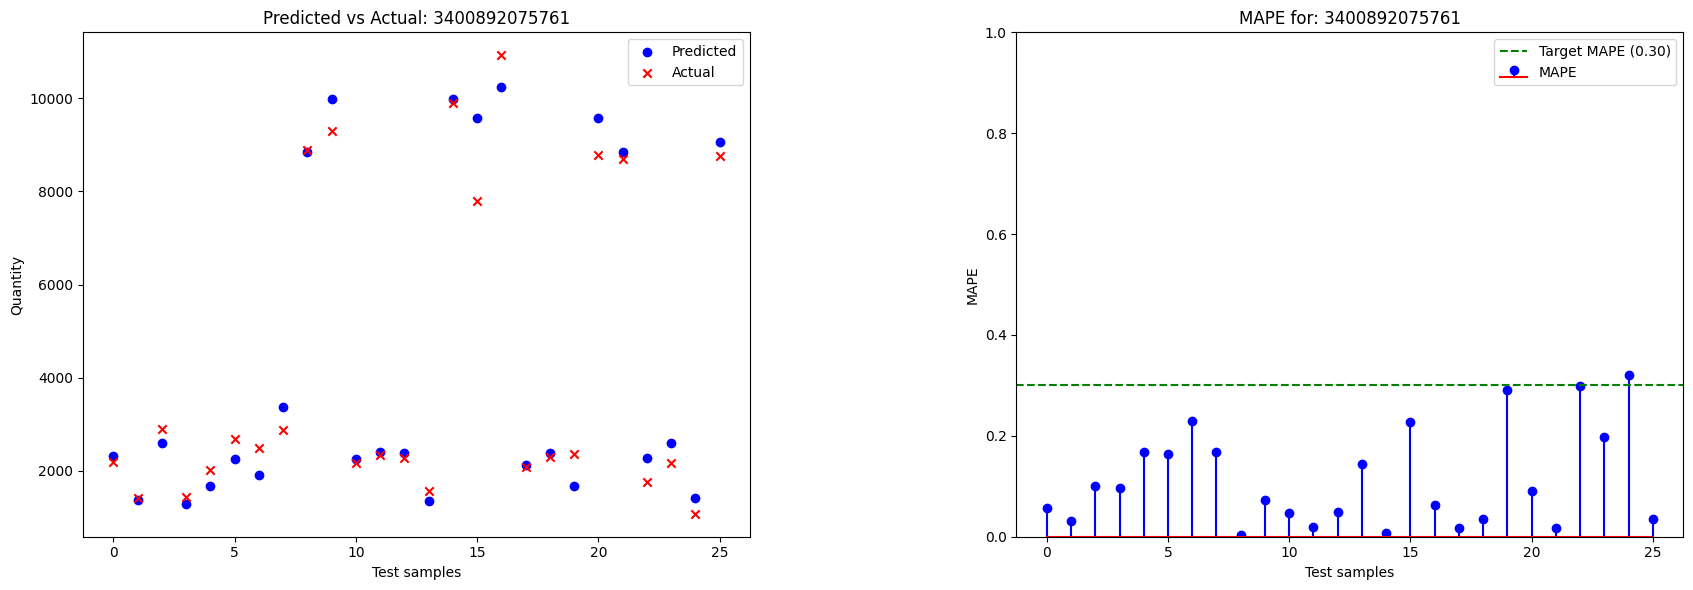



----------------------------------------------------------------------------------------------------
Medicine:3400892203645
Size of data set: 127
Size of training set: 101
Size of test set: 26
Size of grid search: 54
Best Parameters:  {'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 3}
Training Score (MAPE):  -0.389
----------Test scores----------
R^2 Score: 0.727
MAE: 970.28
MAPE: 0.238
RMSE: 1507.444



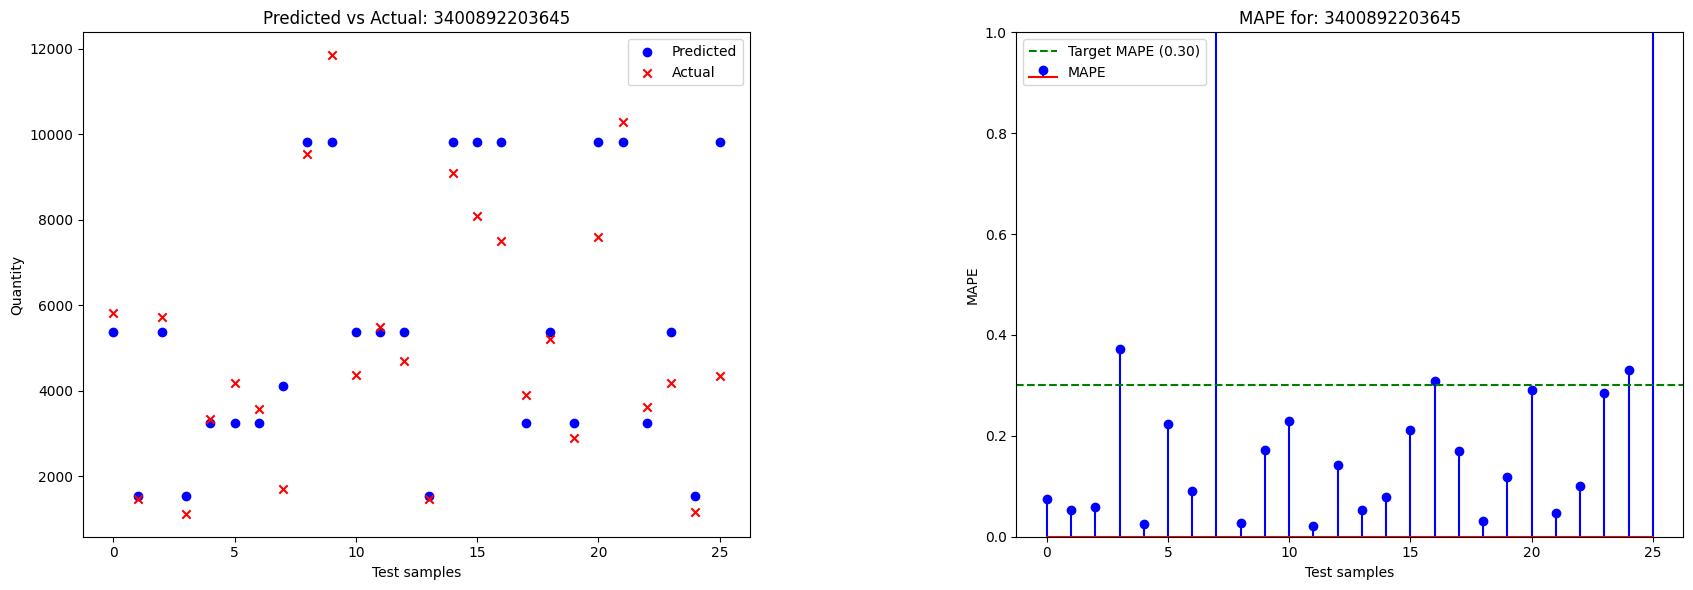



----------------------------------------------------------------------------------------------------
Medicine:3400892065366
Size of data set: 127
Size of training set: 101
Size of test set: 26
Size of grid search: 54
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 6}
Training Score (MAPE):  -1.513
----------Test scores----------
R^2 Score: 0.822
MAE: 1566.451
MAPE: 0.146
RMSE: 2455.108



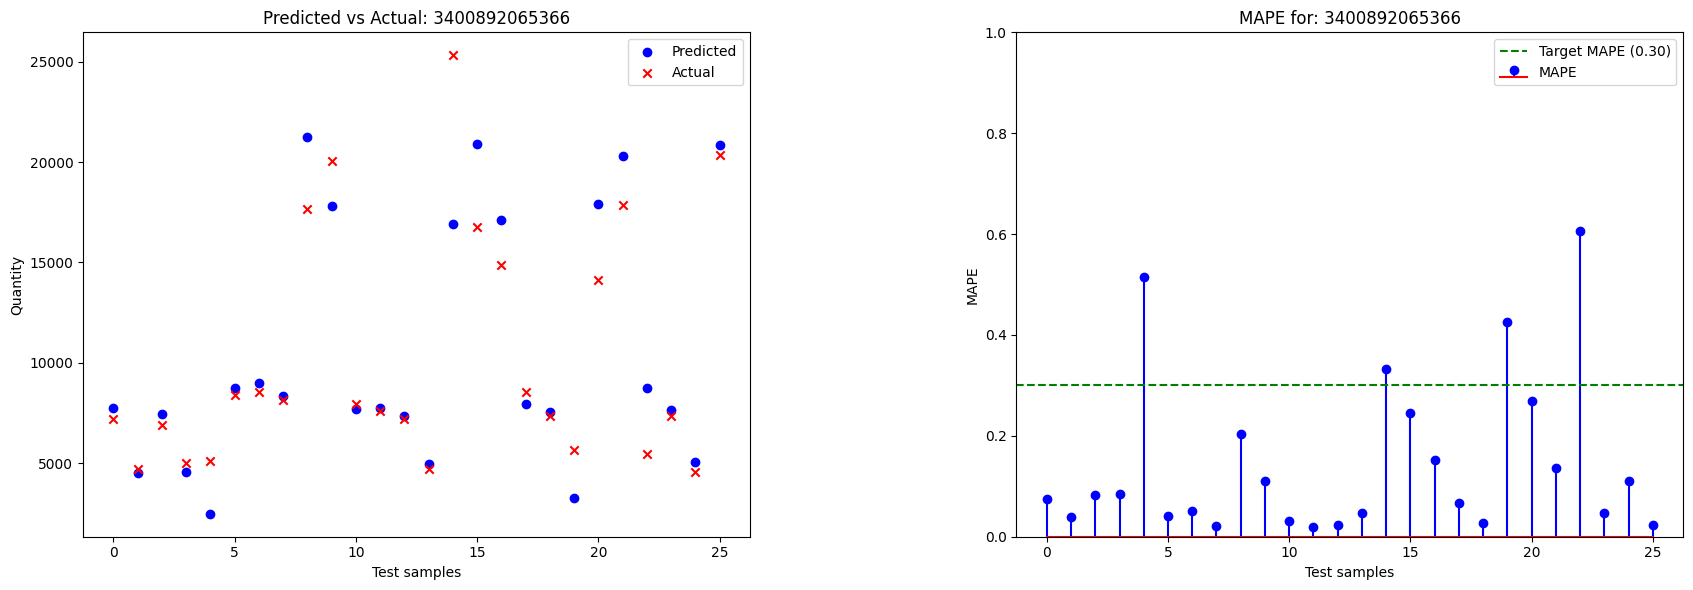



----------------------------------------------------------------------------------------------------
Medicine:3400892052120
Size of data set: 127
Size of training set: 101
Size of test set: 26
Size of grid search: 54
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 3}
Training Score (MAPE):  -0.644
----------Test scores----------
R^2 Score: 0.885
MAE: 666.12
MAPE: 0.156
RMSE: 997.963



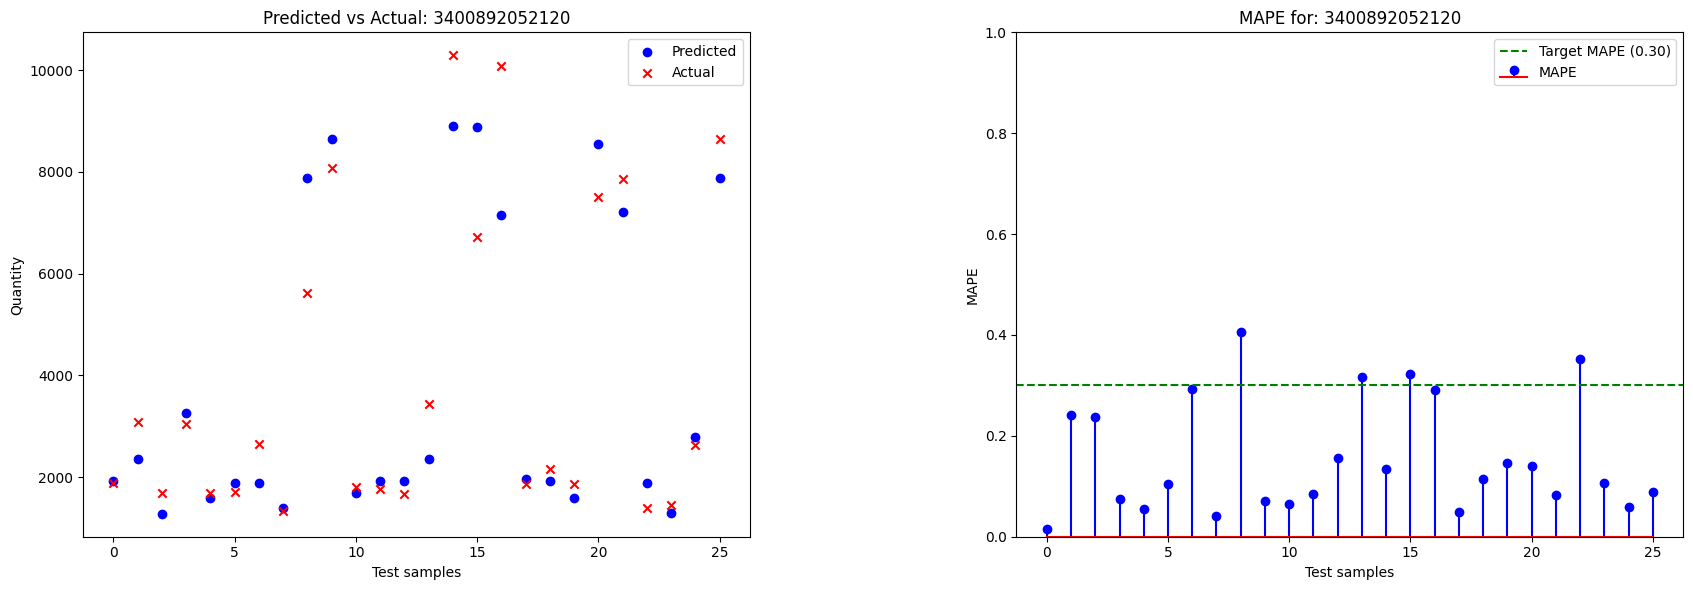



----------------------------------------------------------------------------------------------------
Medicine:3400893826706
Size of data set: 128
Size of training set: 102
Size of test set: 26
Size of grid search: 54
Best Parameters:  {'max_depth': 6, 'max_features': 1, 'n_estimators': 3}
Training Score (MAPE):  -25.538
----------Test scores----------
R^2 Score: 0.817
MAE: 807.269
MAPE: 0.223
RMSE: 994.922



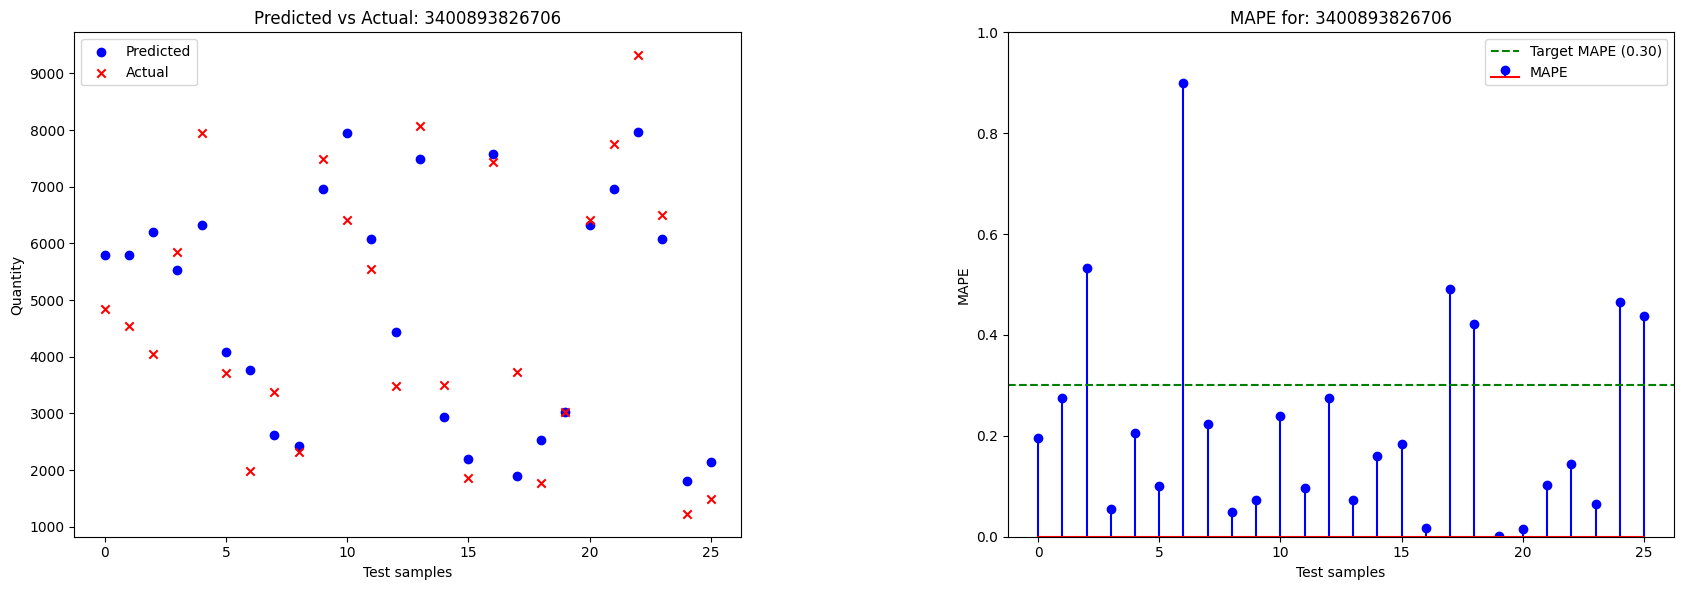



----------------------------------------------------------------------------------------------------
Medicine:3400893736135
Size of data set: 124
Size of training set: 99
Size of test set: 25
Size of grid search: 48
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 3}
Training Score (MAPE):  -0.149
----------Test scores----------
R^2 Score: 0.762
MAE: 779.596
MAPE: 0.143
RMSE: 1022.039



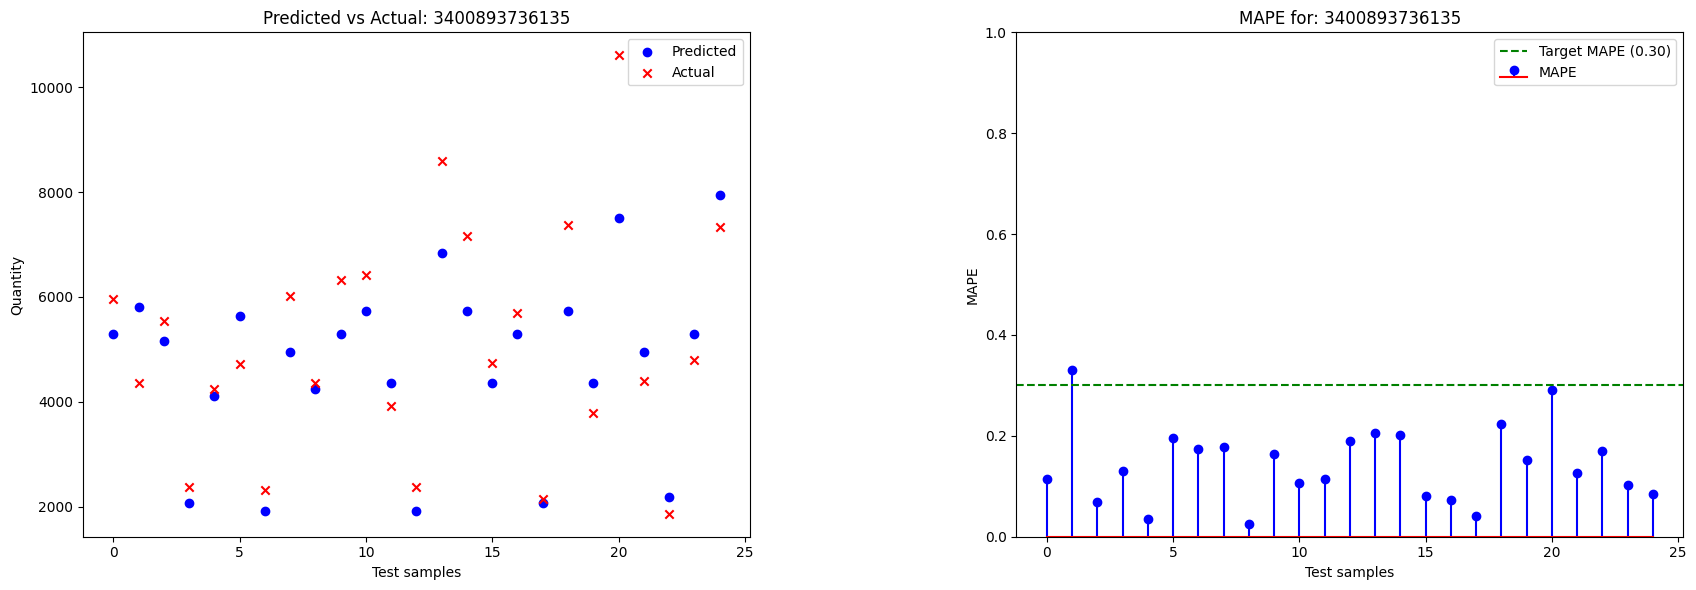



----------------------------------------------------------------------------------------------------
Medicine:3400893875490
Size of data set: 128
Size of training set: 102
Size of test set: 26
Size of grid search: 54
Best Parameters:  {'max_depth': 5, 'max_features': 2, 'n_estimators': 3}
Training Score (MAPE):  -4.781
----------Test scores----------
R^2 Score: 0.884
MAE: 1103.308
MAPE: 0.069
RMSE: 1916.603



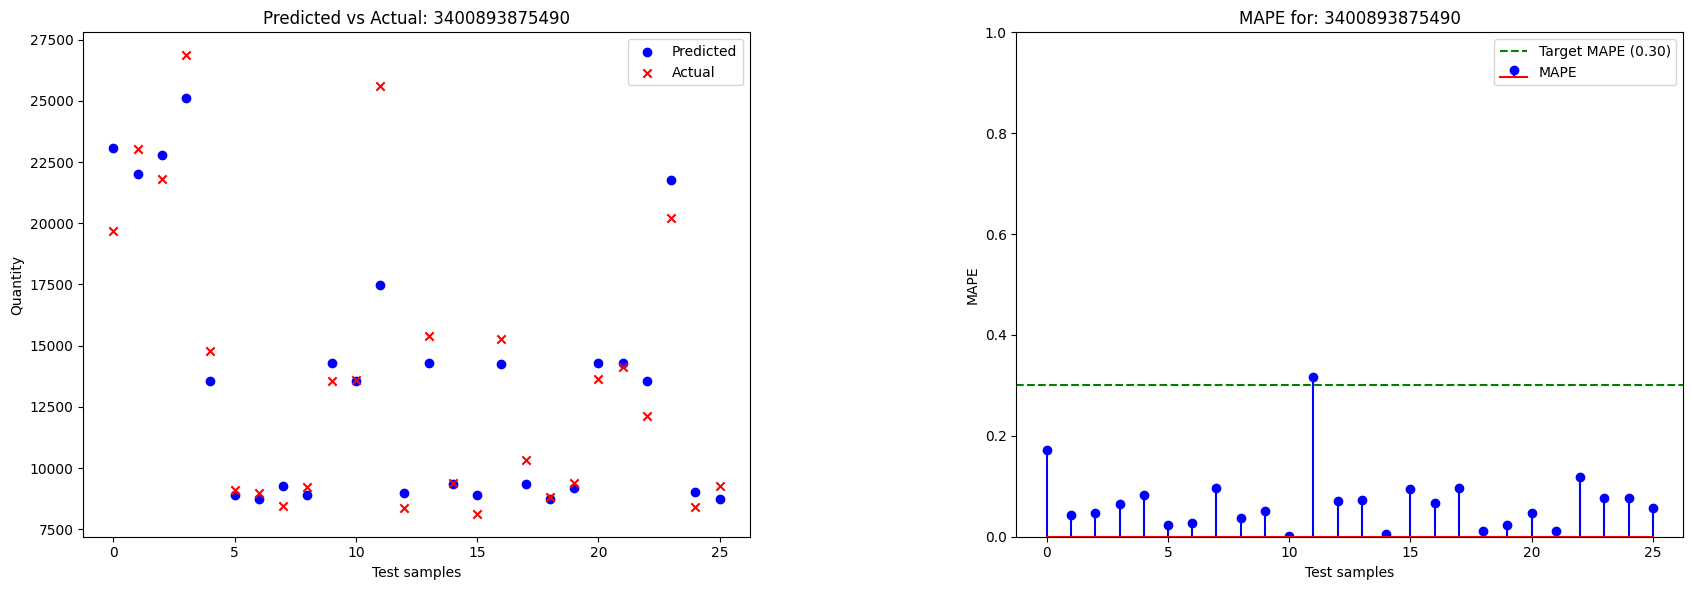



----------------------------------------------------------------------------------------------------
Medicine:3400890837149
Size of data set: 129
Size of training set: 103
Size of test set: 26
Size of grid search: 54
Best Parameters:  {'max_depth': 6, 'max_features': 1, 'n_estimators': 2}
Training Score (MAPE):  -1.56
----------Test scores----------
R^2 Score: 0.653
MAE: 2549.985
MAPE: 55.674
RMSE: 3940.637



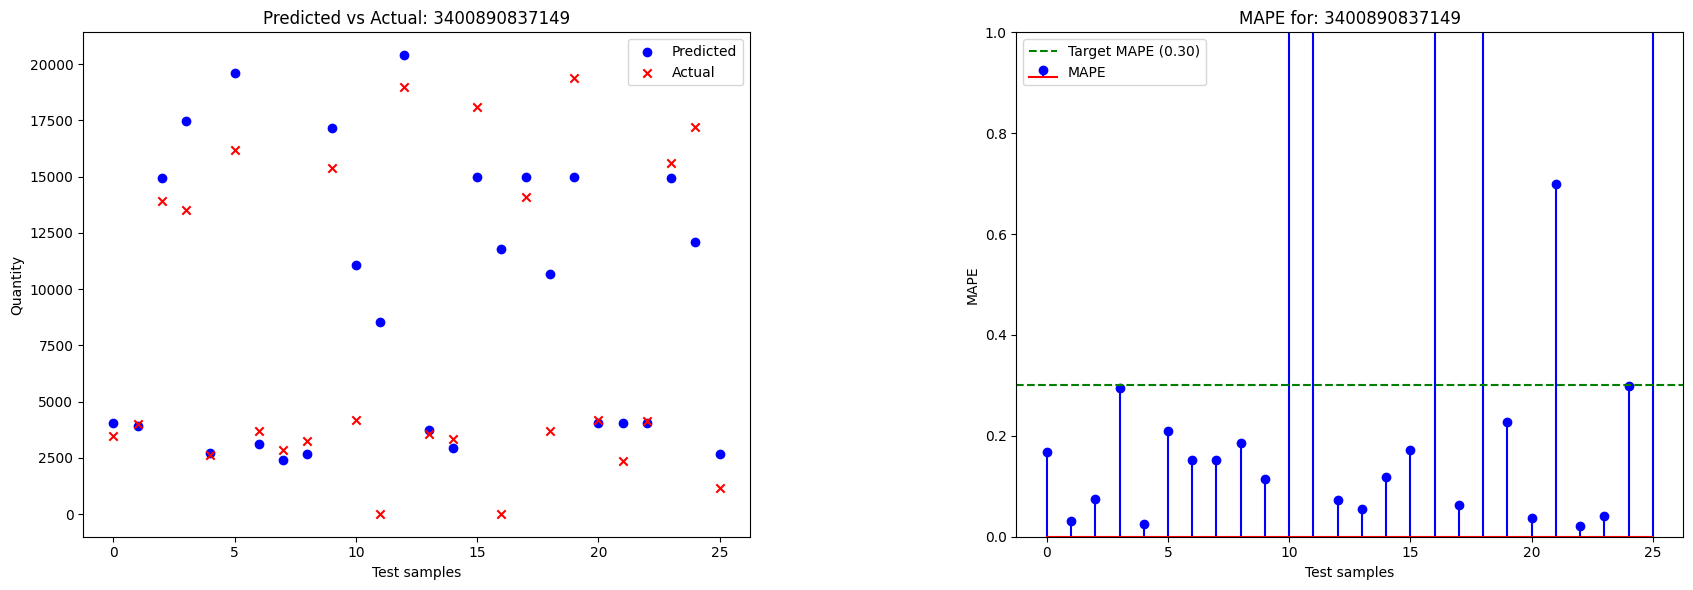



----------------------------------------------------------------------------------------------------
Medicine:3400891235203
Size of data set: 127
Size of training set: 101
Size of test set: 26
Size of grid search: 54
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 6}
Training Score (MAPE):  -0.776
----------Test scores----------
R^2 Score: 0.898
MAE: 509.551
MAPE: 0.183
RMSE: 757.406



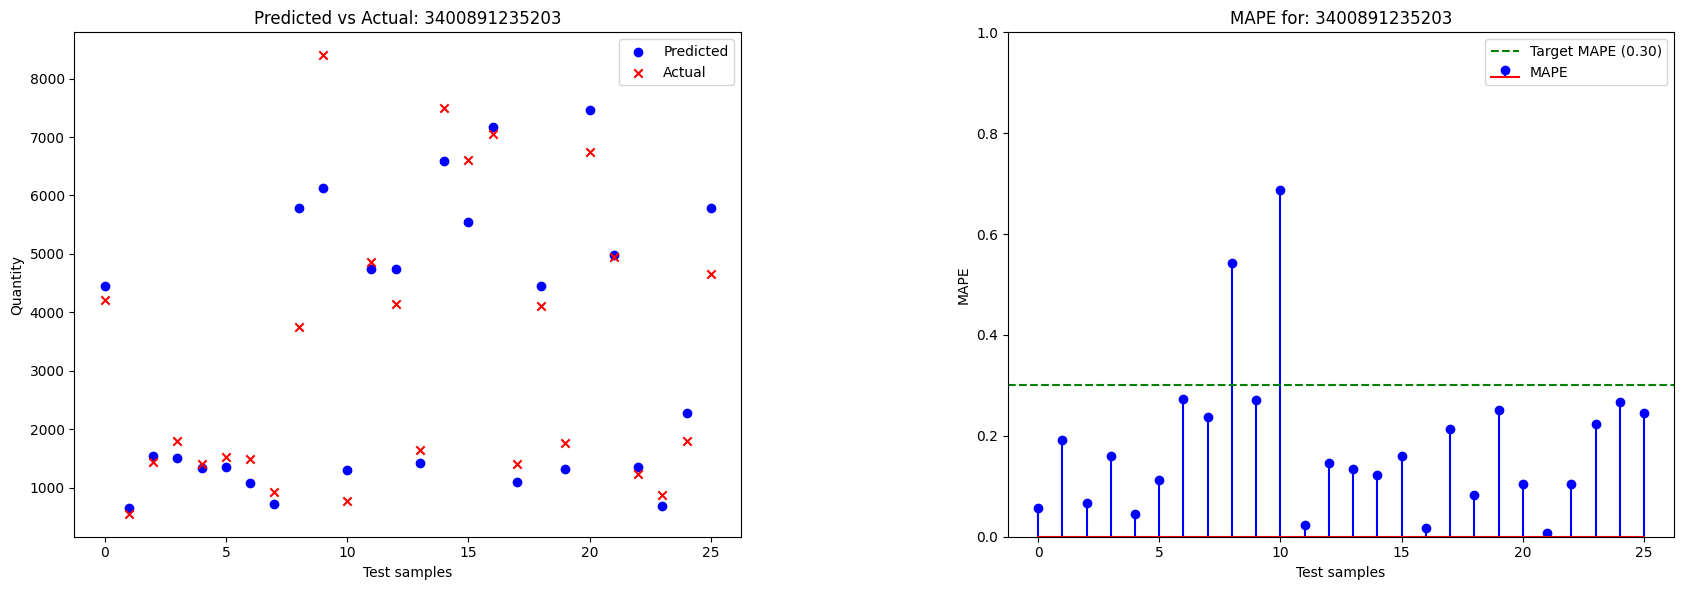



----------------------------------------------------------------------------------------------------
Medicine:3400891225037
Size of data set: 129
Size of training set: 103
Size of test set: 26
Size of grid search: 54
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 2}
Training Score (MAPE):  -1.439
----------Test scores----------
R^2 Score: 0.742
MAE: 2893.463
MAPE: 6.751
RMSE: 3894.823



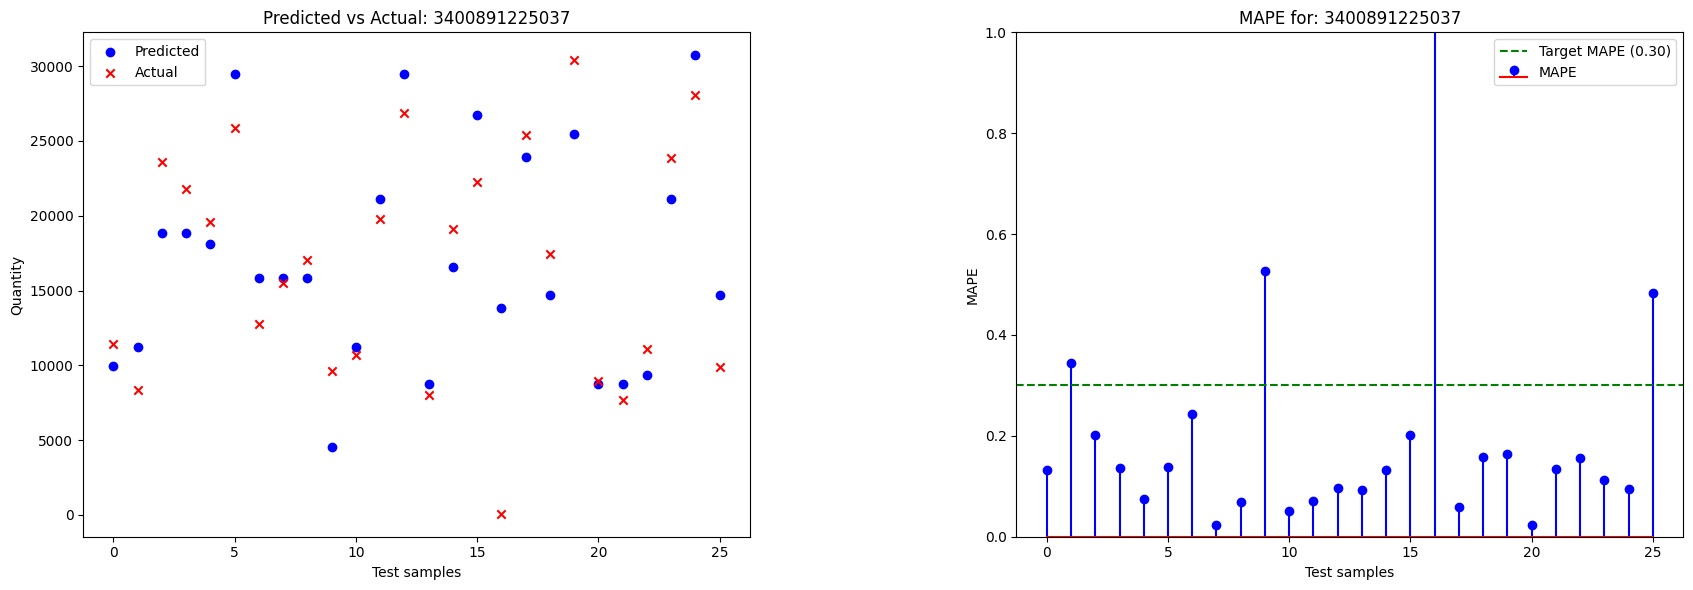



----------------------------------------------------------------------------------------------------
Medicine:3400891191226
Size of data set: 126
Size of training set: 100
Size of test set: 26
Size of grid search: 48
Best Parameters:  {'max_depth': 5, 'max_features': 1, 'n_estimators': 2}
Training Score (MAPE):  -1.091
----------Test scores----------
R^2 Score: 0.684
MAE: 1075.666
MAPE: 0.237
RMSE: 1438.826



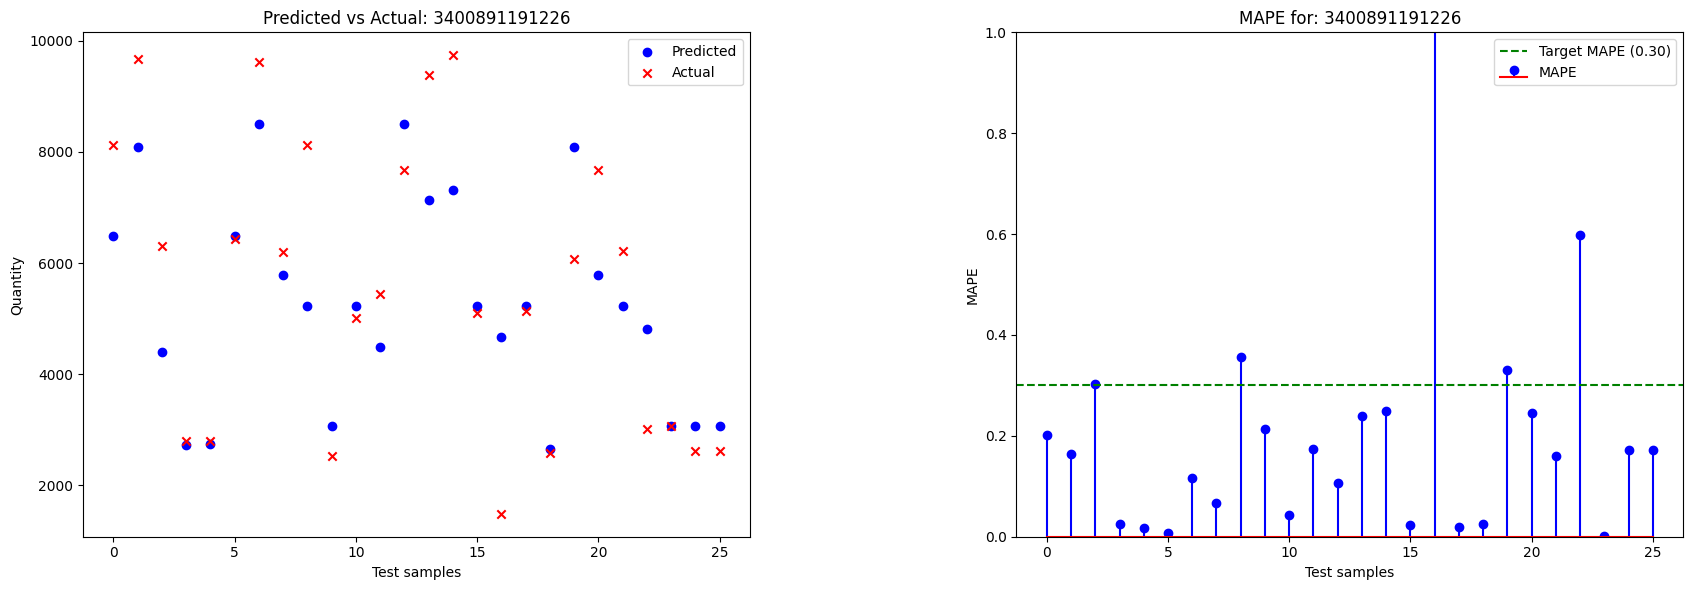



----------------------------------------------------------------------------------------------------
Medicine:3400892729589
Size of data set: 127
Size of training set: 101
Size of test set: 26
Size of grid search: 54
Best Parameters:  {'max_depth': 4, 'max_features': 2, 'n_estimators': 5}
Training Score (MAPE):  -0.133
----------Test scores----------
R^2 Score: 0.851
MAE: 1345.128
MAPE: 15.876
RMSE: 2256.205



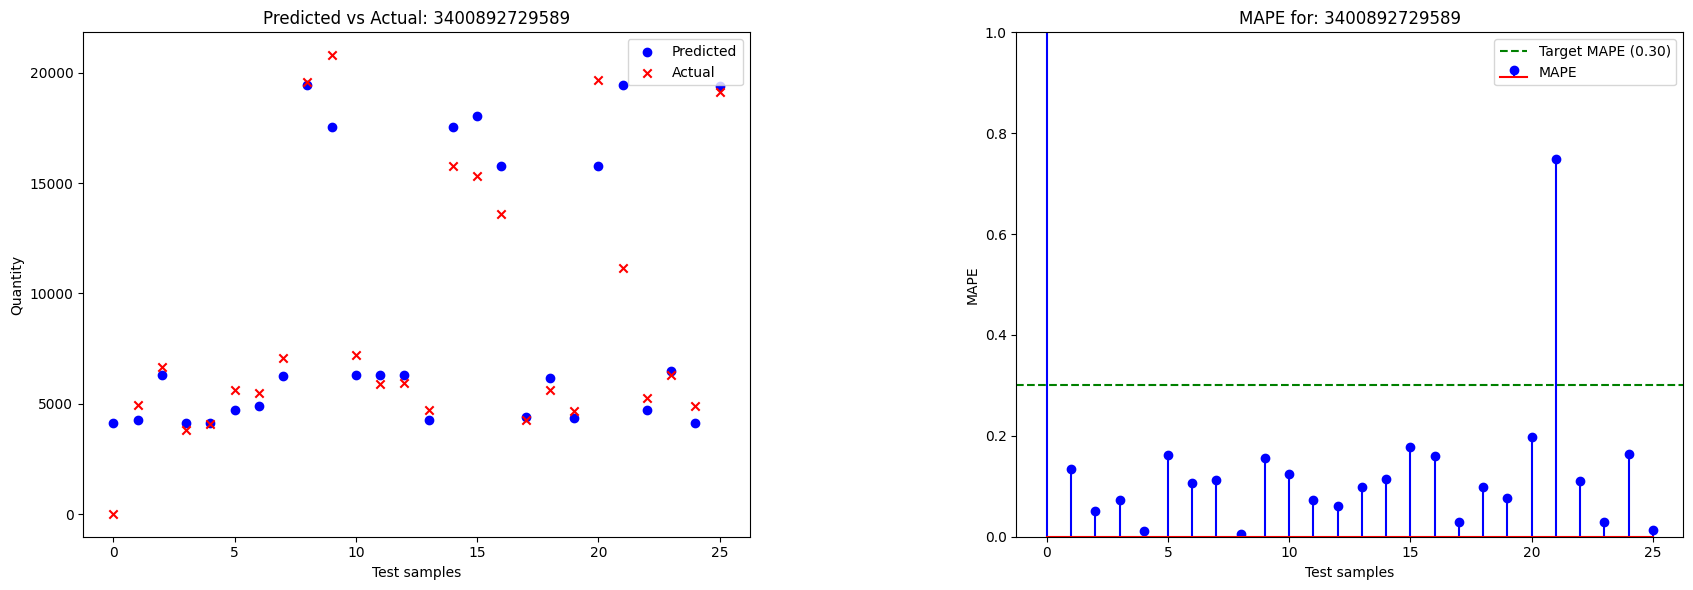



----------------------------------------------------------------------------------------------------
Medicine:3400892745848
Size of data set: 127
Size of training set: 101
Size of test set: 26
Size of grid search: 54
Best Parameters:  {'max_depth': 7, 'max_features': 1, 'n_estimators': 2}
Training Score (MAPE):  -1.431
----------Test scores----------
R^2 Score: 0.918
MAE: 873.195
MAPE: 0.199
RMSE: 1315.148



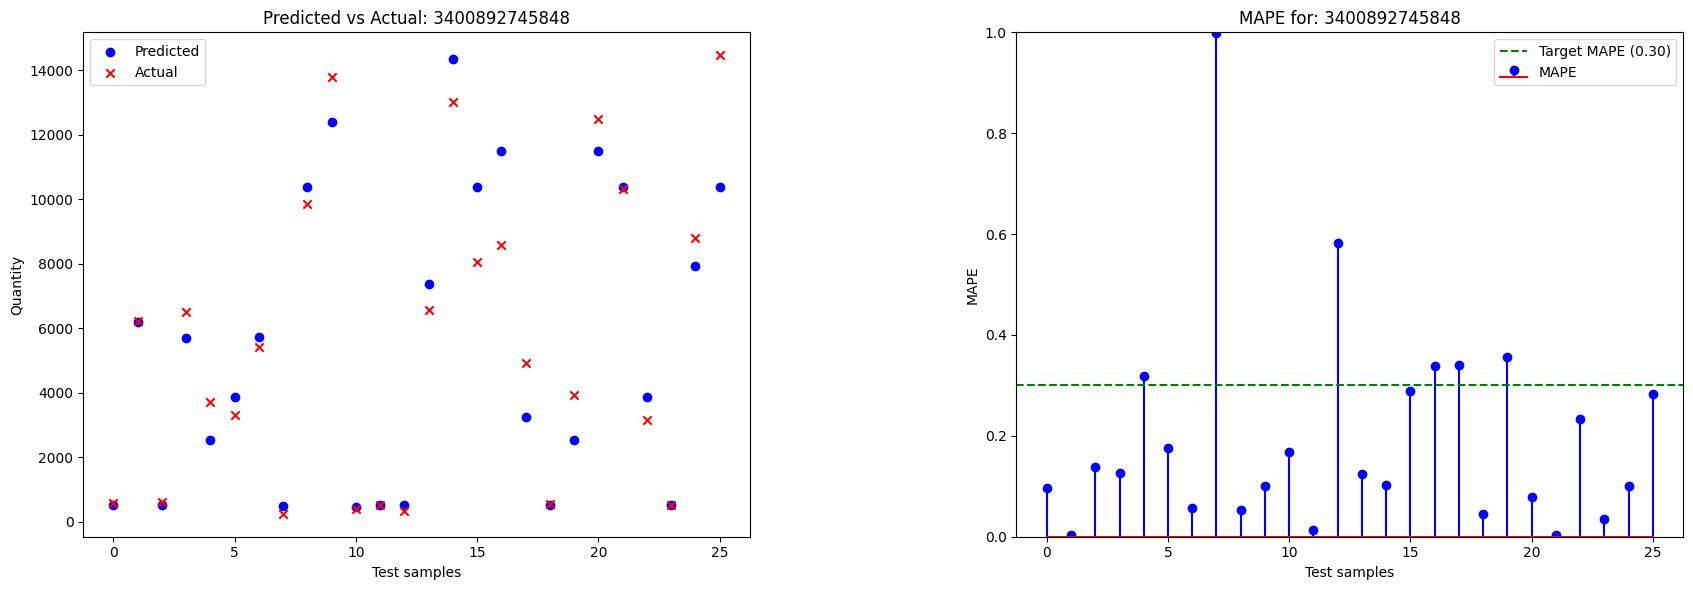



----------------------------------------------------------------------------------------------------
Medicine:3400892697789
Size of data set: 128
Size of training set: 102
Size of test set: 26
Size of grid search: 54
Best Parameters:  {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 4}
Training Score (MAPE):  -1.318
----------Test scores----------
R^2 Score: 0.934
MAE: 518.642
MAPE: 0.256
RMSE: 950.117



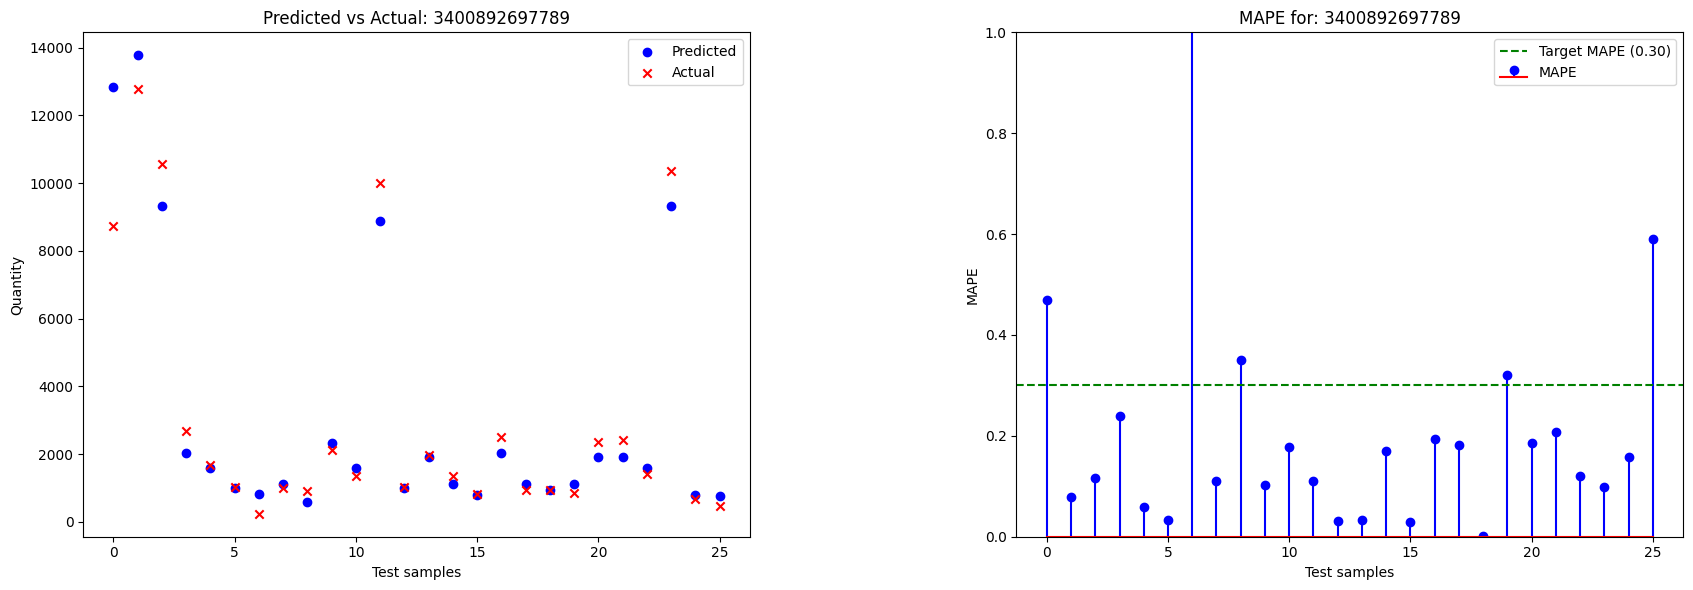



----------------------------------------------------------------------------------------------------
Medicine:3400892761527
Size of data set: 127
Size of training set: 101
Size of test set: 26
Size of grid search: 54
Best Parameters:  {'max_depth': 3, 'max_features': 2, 'n_estimators': 2}
Training Score (MAPE):  -2.98
----------Test scores----------
R^2 Score: 0.925
MAE: 2243.34
MAPE: 0.252
RMSE: 2701.233



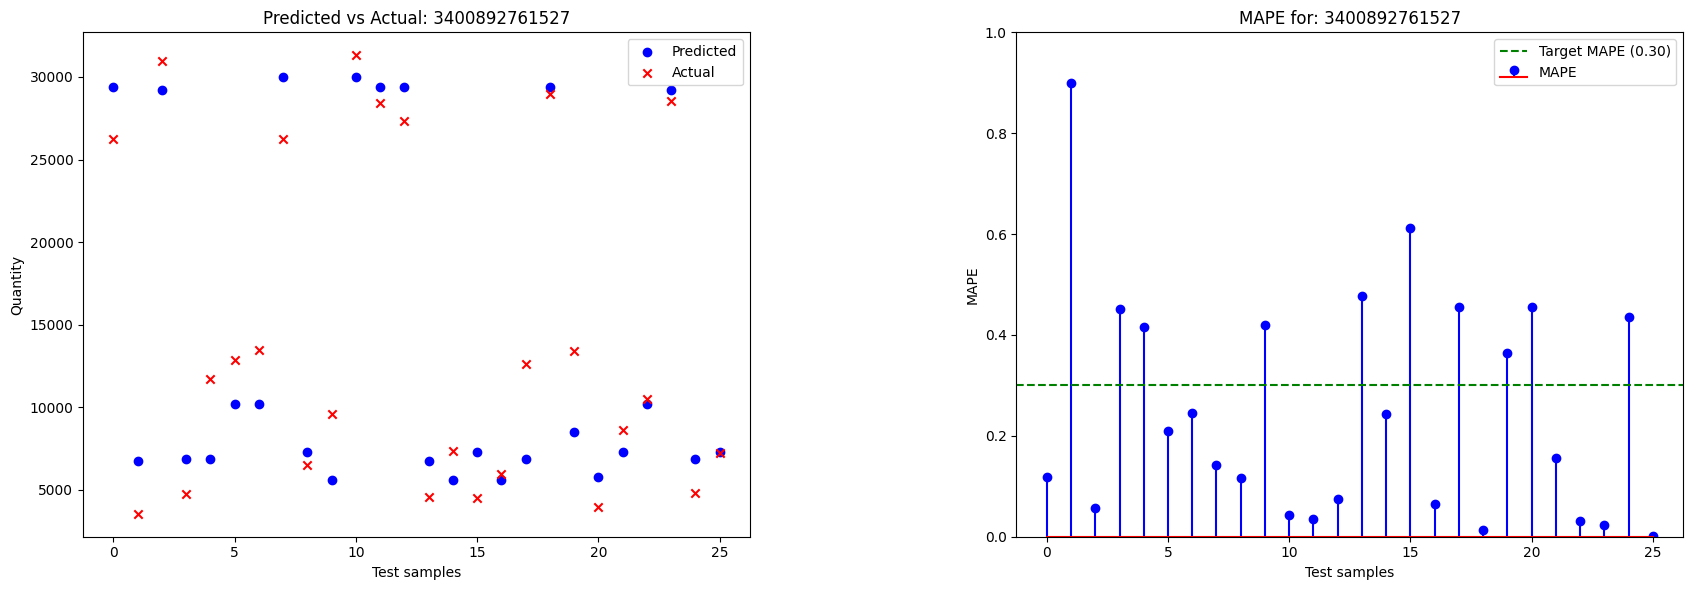



----------------------------------------------------------------------------------------------------
Medicine:3400893022634
Size of data set: 103
Size of training set: 82
Size of test set: 21
Size of grid search: 42
Best Parameters:  {'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 2}
Training Score (MAPE):  -15.232
----------Test scores----------
R^2 Score: 0.355
MAE: 811.323
MAPE: 12.409
RMSE: 1288.105



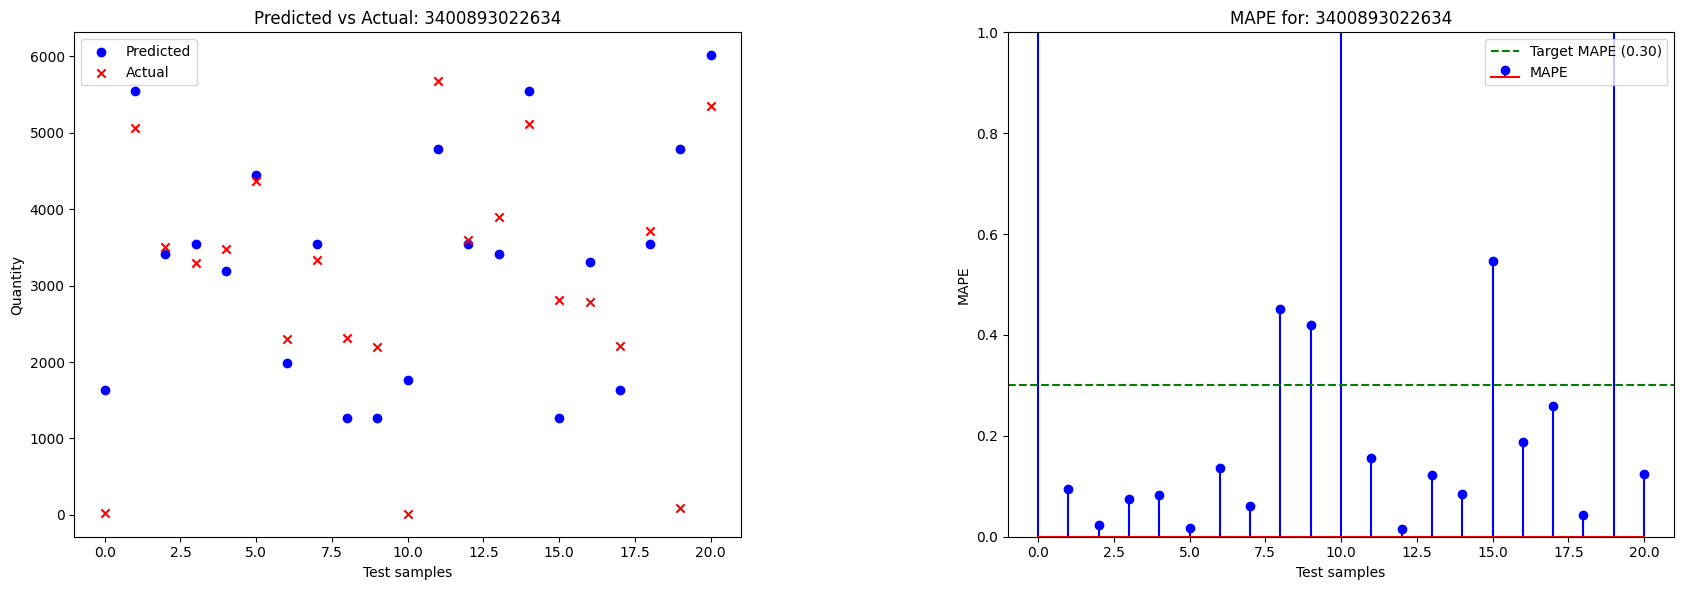



----------------------------------------------------------------------------------------------------
Medicine:3400892761695
Size of data set: 127
Size of training set: 101
Size of test set: 26
Size of grid search: 54
Best Parameters:  {'max_depth': 5, 'max_features': 1, 'n_estimators': 2}
Training Score (MAPE):  -2.573
----------Test scores----------
R^2 Score: 0.828
MAE: 2616.362
MAPE: 0.393
RMSE: 3620.507



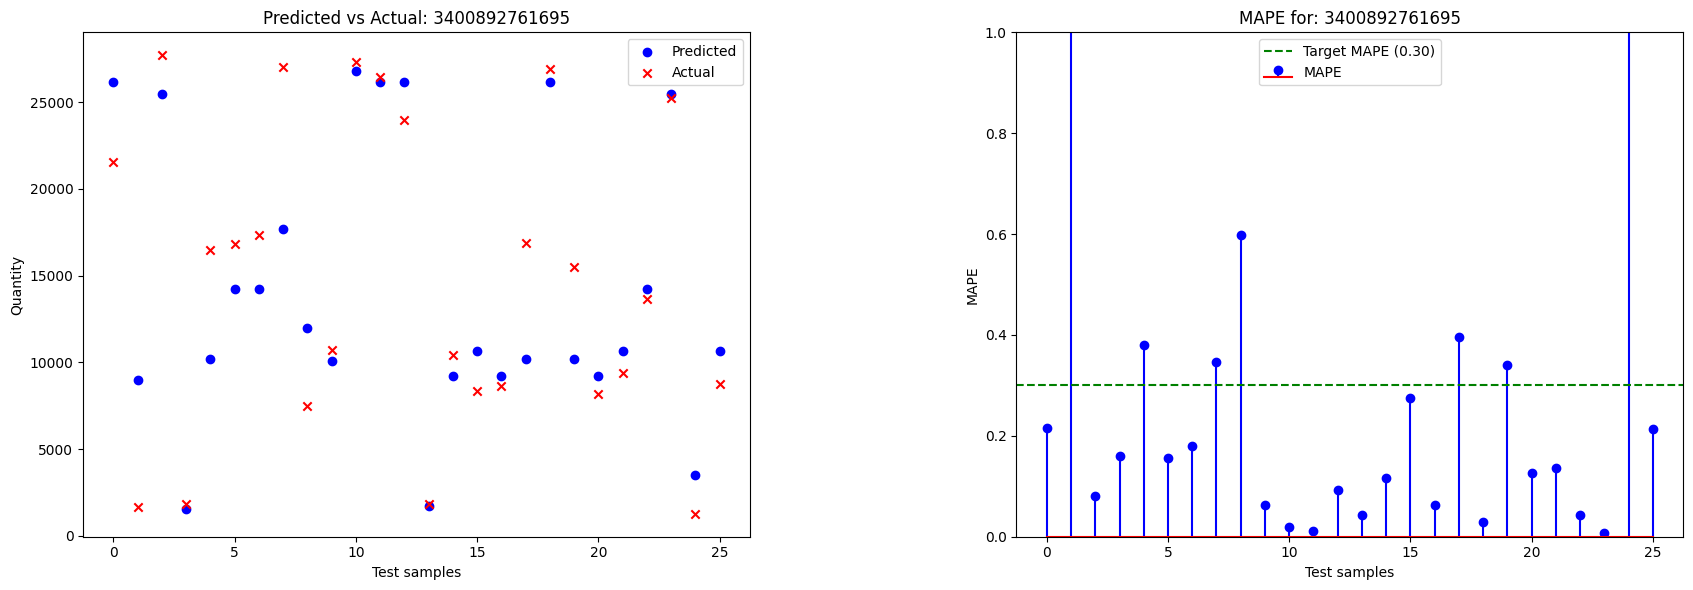



----------------------------------------------------------------------------------------------------
Medicine:3400892669236
Size of data set: 118
Size of training set: 94
Size of test set: 24
Size of grid search: 48
Best Parameters:  {'max_depth': 7, 'max_features': 2, 'n_estimators': 2}
Training Score (MAPE):  -20.264
----------Test scores----------
R^2 Score: 0.844
MAE: 2476.075
MAPE: 0.124
RMSE: 3461.4



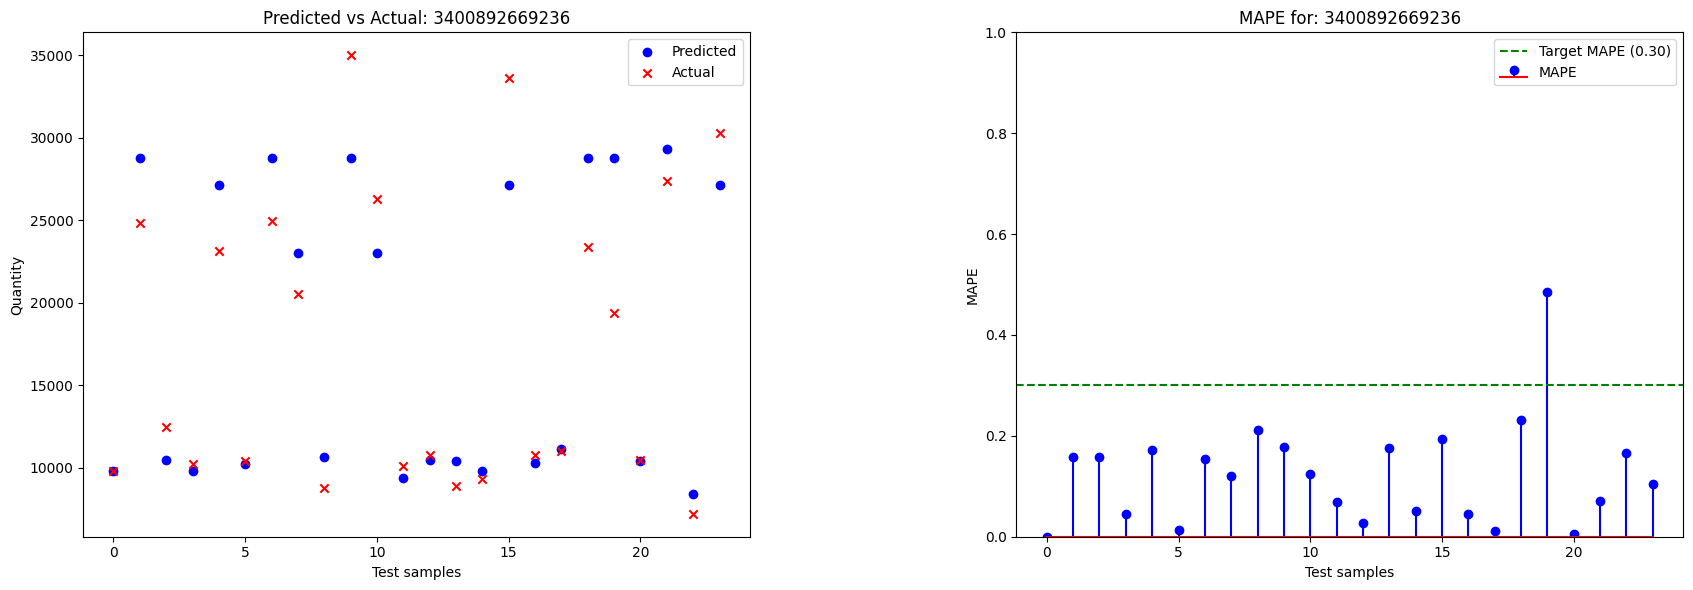



----------------------------------------------------------------------------------------------------
Medicine:3400892508566
Size of data set: 118
Size of training set: 94
Size of test set: 24
Size of grid search: 48
Best Parameters:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 8}
Training Score (MAPE):  -1.353
----------Test scores----------
R^2 Score: 0.783
MAE: 878.649
MAPE: 3.195
RMSE: 1153.37



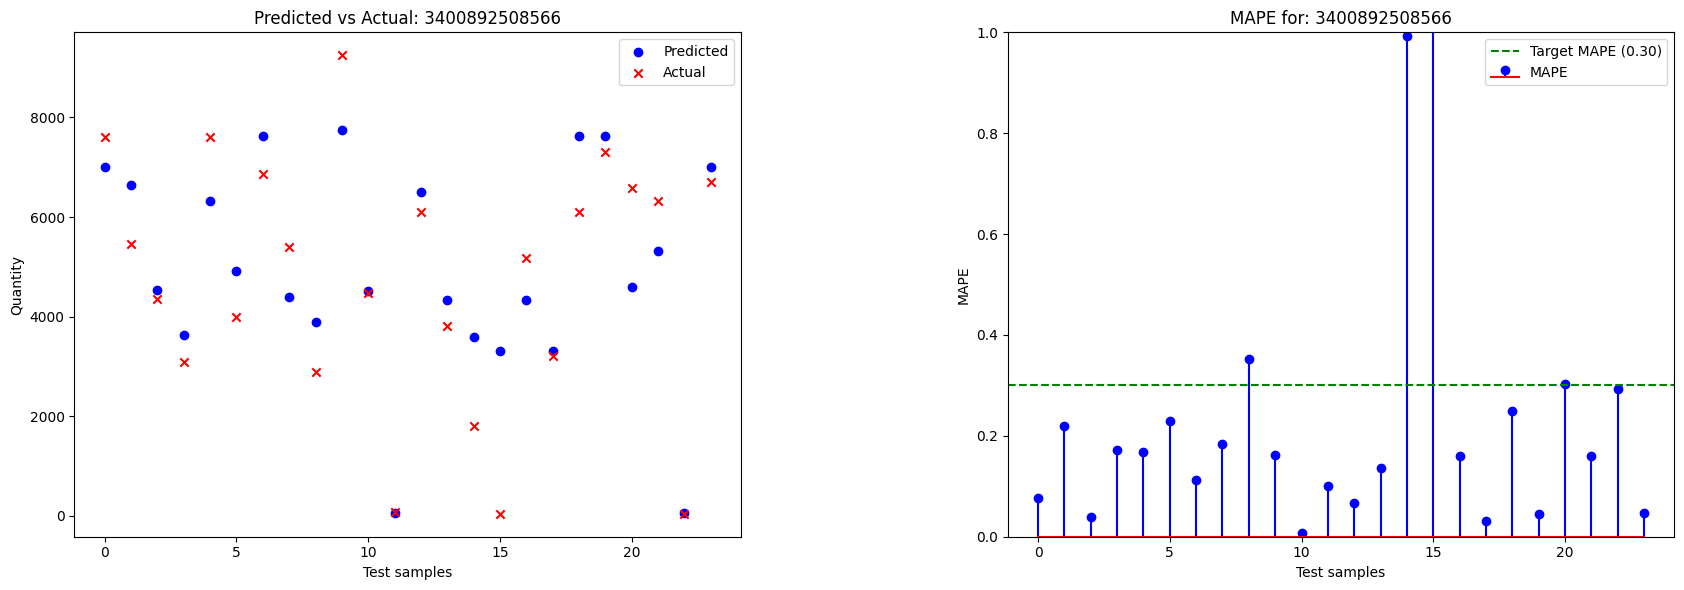

,HOSPI_CODE_UCD,R2,RMSE,MAE,MAPE
0,CODE_UCD_3400892088310,0.822608,750.325448,452.960293,0.103910
1,CODE_UCD_3400892075761,0.975338,517.951268,366.337892,0.113713
2,CODE_UCD_3400892203645,0.727150,1507.444237,970.279905,0.238203
3,CODE_UCD_3400892065366,0.822203,2455.108339,1566.450978,0.145726
4,CODE_UCD_3400892052120,0.885398,997.963334,666.120014,0.155788
5,CODE_UCD_3400891996128,0.000000,0.000000,0.000000,0.000000
6,CODE_UCD_3400893826706,0.817372,994.921563,807.268987,0.222843
7,CODE_UCD_3400893736135,0.762475,1022.038788,779.596438,0.143137
8,CODE_UCD_3400893875490,0.884206,1916.603059,1103.307599,0.069026
9,CODE_UCD_3400890837149,0.652796,3940.636878,2549.984970,55.673691


In [33]:
df_prediction_scores = pd.DataFrame(columns=['HOSPI_CODE_UCD', 'R2', 'RMSE', 'MAE', 'MAPE'])

for medicine in medicines:
  if medicine == '3400891996128':
    # Create the new row as a DataFrame
    new_row = pd.DataFrame({'HOSPI_CODE_UCD': ['CODE_UCD_'+str(medicine)],
                            'R2': [0],
                            'RMSE': [0],
                            'MAE': [0],
                            'MAPE': [0]})

    # Append the new row to the DataFrame
    df_prediction_scores = pd.concat([df_prediction_scores, new_row], ignore_index=True)

  else:
    df_prediction_scores = test_1_baseline(df_agg_clusters_4.drop(['CLUSTER'], axis = 1), medicine, df_prediction_scores)

df_prediction_scores

In [34]:
df_prediction_scores.to_csv('df_scores_temp_ts_baseline.csv', index=False)

In [ ]:
def test_2_clustering(df, df_scores, medicines):

  for cluster in df.CLUSTER.unique():
    print()
    print(100*'-')
    print(f'Cluster: {cluster}')

    # Perform the train-test split with shuffled samples
    X = df[df['CLUSTER'] == cluster].drop(['DATE', 'QUANTITY', 'CLUSTER', 'QUANTITY_MA', 'TREND', 'SEASONAL', 'RESID'], axis=1).copy().values
    y = df[df['CLUSTER'] == cluster]['QUANTITY'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2, shuffle = True)
    print(f'Size of data set: {len(X_train) + len(X_test)}')
    print(f'Size of training set: {len(X_train)}')
    print(f'Size of test set: {len(X_test)}')

    df_test = pd.DataFrame(X_test, columns = df.drop(['DATE', 'QUANTITY', 'CLUSTER', 'QUANTITY_MA', 'TREND', 'SEASONAL', 'RESID'], axis=1).copy().columns)
    df_test['QUANTITY'] = y_test


    # Define the parameter distributions for RandomizedSearchCV
    param_grid = {
        'max_depth': np.arange(2, 8, 1),
        'n_estimators': np.arange(2, max(int(m.ceil(len(X_train)*0.1)),3), 1),
        'max_features': ['sqrt', 1, 2]
    }

    depth_len = param_grid['max_depth'].size
    estimators_len = param_grid['n_estimators'].size

    print(f'Size of grid search: {depth_len * estimators_len}')

    # Create the RandomizedSearchCV object
    grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                              param_grid=param_grid,
                              scoring = 'neg_mean_absolute_percentage_error',
                              cv = 5,
                              n_jobs = -1)

    ''' >3 : the fold and candidate parameter indexes
        are also displayed together with the starting time of the computation.
    '''


    # Fit the RandomizedSearchCV object to the data
    grid_search.fit(X_train[:,1:], y_train)

    print("Finished training")

    # Get the best estimator
    best_estimator = grid_search.best_estimator_

    for medicine in df_test.HOSPI_CODE_UCD.unique():
      print()
      print(100*'-')
      print('Medicine:' + str(medicine))

      X_test_medicine = df_test[df_test['HOSPI_CODE_UCD'] == medicine].drop(['QUANTITY', 'HOSPI_CODE_UCD'], axis=1).copy().values

      scaler = StandardScaler()
      X_test_scaled = scaler.fit_transform(X_test_medicine)

      y_test_medicine = df_test[df_test['HOSPI_CODE_UCD'] == medicine]['QUANTITY'].copy().values

      # Make predictions using the best estimator
      y_pred = best_estimator.predict(X_test_scaled)

      # Calculate R^2 score
      r2 = r2_score(y_test_medicine, y_pred)

      # Calculate MAE
      mae = mean_absolute_error(y_test_medicine, y_pred)

      # Calculate MAPE
      mape = mean_absolute_percentage_error(y_test_medicine, y_pred)

      # Calculate RMSE
      rmse = np.sqrt(mean_squared_error(y_test_medicine, y_pred))

      # Print the best parameters, best score, and evaluation metrics

      # Print the best parameters, best score, and evaluation metrics
      print('Best Parameters: ', grid_search.best_params_)
      print('Training Score (MAPE): ', round(grid_search.best_score_, 3))
      print(10*'-' + 'Test scores' + 10*'-')
      print('R^2 Score:', round(r2, 3))
      print('MAE:', round(mae, 3))
      print('MAPE:', round(mape, 3))
      print('RMSE:', round(rmse, 3))
      print()


      # Create the new row as a DataFrame
      new_row = pd.DataFrame({'CLUSTER': [cluster],
                              'HOSPI_CODE_UCD': ['CODE_UCD_'+str(int(medicine))],
                              'R2': [r2],
                              'RMSE': [rmse],
                              'MAE': [mae],
                              'MAPE': [mape]})

      # Append the new row to the DataFrame
      df_scores = pd.concat([df_scores, new_row], ignore_index=True)

      plot_pred(y_pred, y_test_medicine, medicine)
      print()


  # Return the updated DataFrame
  return df_scores

In [ ]:
'''df_prediction_scores_agg = pd.DataFrame(columns=[ 'HOSPI_CODE_UCD', 'CLUSTER', 'R2', 'RMSE', 'MAE', 'MAPE'])

df_prediction_scores_agg = test_2_clustering(df_agg_clusters, df_prediction_scores_agg, medicines)

df_prediction_scores_agg'''

In [ ]:
'''df_prediction_scores_pca = pd.DataFrame(columns=[ 'HOSPI_CODE_UCD', 'CLUSTER', 'R2', 'RMSE', 'MAE', 'MAPE'])

df_prediction_scores_pca = test_2_clustering(df_clustered_pca, df_prediction_scores_pca, medicines)

df_prediction_scores_pca'''